# Dataset Overview (for Amazon Reviews, Essays)

This notebook presents a data analysis for both the Amazon reviews and essays datasets. The information found in this analysis was used to make decisions for designing the pipelines and tokenization methods. You can run individual cells to get insights about your particular version of the dataset.

### Imports
Run this cell first to load the important functions and libraries

In [8]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from data.dataset import load_reviews, load_essays

# Amazon Reviews
You must run this cell in order to load the Amazon reviews so that you can run subsequent cells.

In [4]:
reviews_data = load_reviews()

In [5]:
reviews_data.head()

,index,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,type
0,0,5,3.0,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN,digital_music
1,1,5,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN,digital_music
2,2,5,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN,digital_music
3,3,4,3.0,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN,digital_music
4,4,5,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN,digital_music


### Sample Reviews

In [6]:
def show_reviews(nsample=1):
    for group in reviews_data.groupby('type'):
        group = group[1].reset_index()
        print('---------------------------------- ({t}) --------------------------------'.format(t=group['type'][0]))
        for _, row in group.sample(n=nsample).iterrows():
            print('\n(Score: {s})  {r}\n'.format(s=row['overall'], r=row['reviewText']))
            print("---------------------------------------------------------------------------")

show_reviews(2)

---------------------------------- (digital_music) --------------------------------

(Score: 4)  good song

---------------------------------------------------------------------------

(Score: 3)  This is an album the Blue Oyster Cult fans will really get into, a concept album that showcases the bands unique song stylings. For the casual listener, or sometime BOC fan, stick with "Agents of Fortune" or "Fire of Unknown Origin". "Imaginos" is a heavy album and features a great remake of "Astronomy", the best song on the CD. But unless you are prepared to invest some time, deciphering the story, and songs you won't get much out of the album. I picked up "Imaginos" on CD after hearing "Astronomy" late at night (the best time to play the CD), and there was a narrative about the "Imaginos" myth read by Stephen King as the song opened. I heard this only two times on the radio, and picked up the CD because I was a huge Stephen King fan, and enjoyed some of BOC's earlier albums. Needless to say

### Summary Statistics

In [7]:
LEFT_ADJUST = 28

for dataset in ['all', *reviews_data['type'].unique()]:
    data = reviews_data if (dataset=='all') else reviews_data[reviews_data['type']==dataset]
    
    word_tokens = set()
    char_tokens = set()
    sum_rev_len = 0
    for text in data['reviewText']:
        if type(text) == str:
            sum_rev_len += len(text)
            for token in re.split(r'\s{1,}', text):  word_tokens.add(token)
            for c in text:  char_tokens.add(c)
    print("------------- ({s}) --------------".format(s=dataset))
    print("# Reviews:  ", len(data))
    print("# Unique words:  ", len(word_tokens))
    print("# Unique characters:  ", len(char_tokens))
    print("Average Review Length:  ", np.round_(sum_rev_len / len(data), 2), "chars")
    print("Average Overall Rating:  ", np.round_(data['overall'].mean(), 2))
    counts = data['overall'].value_counts()
    print("Rating Count (by score):  '1': {s1}  '2': {s2}  '3': {s3}  '4': {s4}  '5': {s5} ".format(
        s1=counts[1], s2=counts[2], s3=counts[3], s4=counts[4], s5=counts[5]))
    print()
print()
print("------------------- Score Summaries -------------------")
print((" "*LEFT_ADJUST + "\tavg rating\tmax\tmin\n"))
for group in reviews_data.groupby('type'):
    df = group[1]
    print(group[0].ljust(LEFT_ADJUST) + "\t{avg}\t{mm}\t{mx}".format(
        avg=np.round_(df['overall'].mean(), 8),
        mn=df['overall'].max(),
        mx=df['overall'].min()
    ))
print()
print("Possible values for 'overall':\t", sorted(reviews_data['overall'].unique()))

------------- (all) --------------
# Reviews:   40000
# Unique words:   133533
# Unique characters:   97
Average Review Length:   416.88 chars
Average Overall Rating:   4.43
Rating Count (by score):  '1': 1643  '2': 1218  '3': 2970  '4': 6599  '5': 27570 

------------- (digital_music) --------------
# Reviews:   5000
# Unique words:   19758
# Unique characters:   92
Average Review Length:   167.71 chars
Average Overall Rating:   4.74
Rating Count (by score):  '1': 58  '2': 29  '3': 163  '4': 660  '5': 4090 

------------- (luxury_beauty) --------------
# Reviews:   5000
# Unique words:   23773
# Unique characters:   93
Average Review Length:   386.72 chars
Average Overall Rating:   4.32
Rating Count (by score):  '1': 207  '2': 208  '3': 512  '4': 917  '5': 3156 

------------- (musical_instruments) --------------
# Reviews:   5000
# Unique words:   23385
# Unique characters:   94
Average Review Length:   275.23 chars
Average Overall Rating:   4.54
Rating Count (by score):  '1': 112  '

### Distribution of Scores

The score of '5' appears to be most common in the data. This could cause issues related to class imbalance. There are two ways to deal with this which will be shown in subsequent charts:
- **Binarization**:  translate the scores into binary categories ('0': bad (1-4) '1': good (5)). This will allow us to use all of the data, but at the expense of expressiveness for the scores.
- **Re-weighting**:  weigh the individual class scores by their prevalance in the data. In this case, the lower scores should be weighed higher.

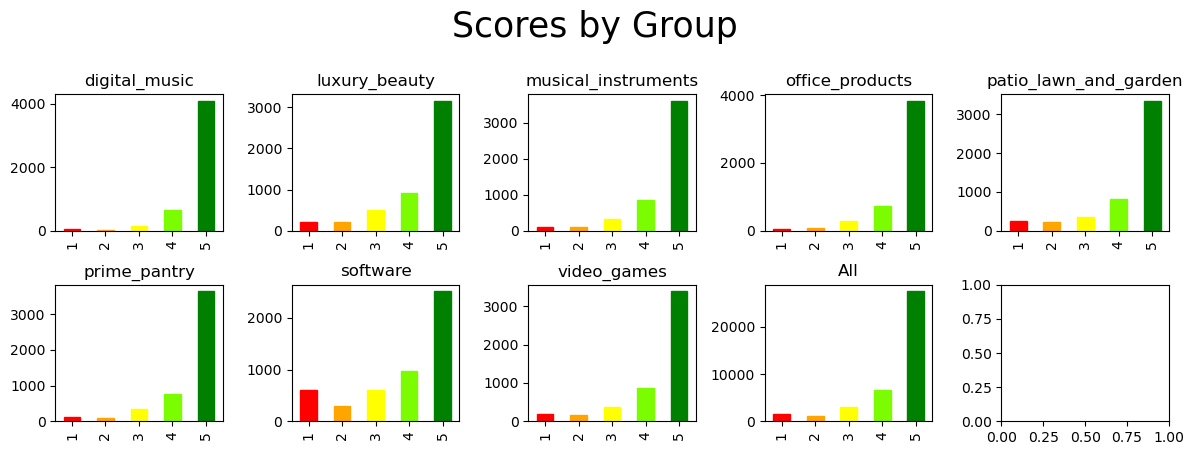

In [18]:
def create_reviews_plot(df, title, bin=False):
    group_types = df['type'].unique()
    nrows = ((len(group_types) + 2) // 5)
    ncols = len(group_types) if (len(group_types) < 5) else 5
    plot_height = 1.5*(nrows + 1)
    fig, ax = plt.subplots(nrows, ncols, figsize=(12, plot_height))
    fig.suptitle(title, size=25, y=1.0)
    
    colors_dict = {0: 'red', 1: 'blue'} if (bin) else {0: 'red', 1: 'orange', 2: 'yellow', 3: 'lawngreen', 4: 'green'}
    for r in range(len(ax)):
        for c in range(len(ax[0])):
            idx = r*len(ax[0]) + c
            if idx < len(group_types):
                p = df[df['type'] == group_types[idx]]['overall'].value_counts().sort_index()
                bar = p.plot.bar(ax=ax[r][c], title=group_types[idx])
            elif idx == len(group_types):
                bar = df['overall'].value_counts().sort_index().plot.bar(ax=ax[r][c], color={'red', 'orange', 'yellow', 'lawngreen', 'green'}, title="All")
            else:
                break
            for i in range(len(bar.patches)):  bar.patches[i].set(color=colors_dict[i])
    fig.tight_layout()
    
create_reviews_plot(reviews_data, "Scores by Group")

### Binarized Scores:

The below charts show the distribution of binary scores with a threshold of **4** (so '1' is the same as '5' in this case). Even after binarization, there's still a clear bias towards positive reviews. Thus, we will use class re-weighting as our primary method for dealing with class imbalance.

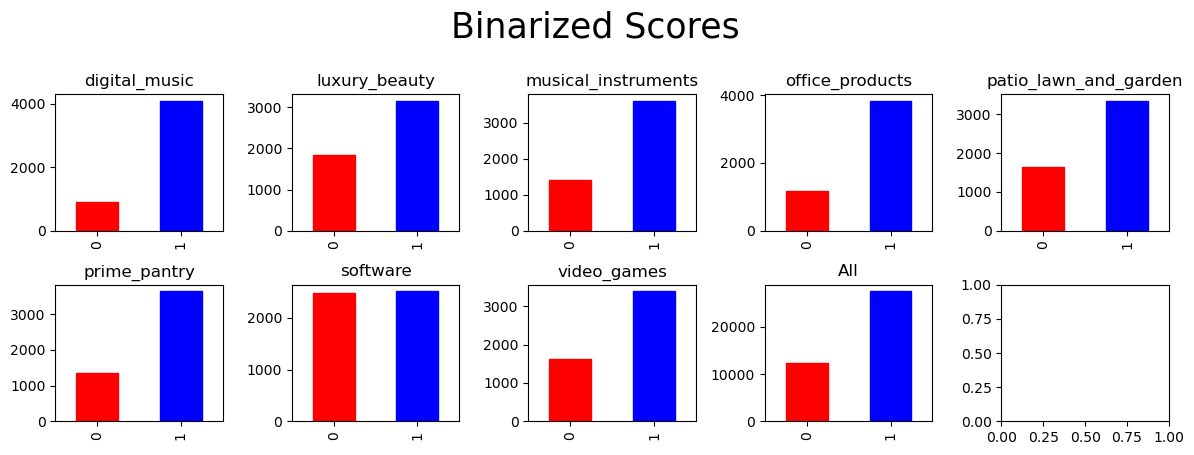

In [19]:
# thresh:  values <= thresh will be assigned negative (0), above will be assigned positive (1)
def binarize(df, thresh=4):
    new_df = df.copy()
    new_df['overall'] = (new_df['overall'] > thresh).astype(int)
    return new_df

create_reviews_plot(binarize(reviews_data), title="Binarized Scores", bin=True)

# Hewlett Foundation Essays

This dataset comes with its own training, validation, and test sets. Additionally; there are 8 different categories (essay sets), and each is associated with a particular prompt, score range, and particular set of rules. Refer to **Essay_Set_Descriptions** (inside of the *kaggle/* dataset directory, unzip the folder) for specific information about each set.

## Load Essays

Remember to download the dataset into *dataset/kaggle* from here:  https://www.kaggle.com/competitions/asap-aes/data

You must run this cell in order to run subsequent cells using this data.

In [167]:
essays_train, essays_valid, essays_test = load_essays()

# convert '' to <NA>, convert score columns into Int64
for df in [essays_train, essays_valid, essays_test]:
    df.replace(['', '<NA>'], np.nan, inplace=True)
    for col in (c for c in df.columns if c not in ['essay_id', 'essay_set', 'essay']):
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
essays_train.dropna(subset=['essay', 'domain1_score'], inplace=True)
essays_train.reset_index(inplace=True)

load train dataset/kaggle\training_set_rel3.xls
load validation dataset/kaggle\valid_set.xls
load test dataset/kaggle\test_set.tsv


### Train:

In [62]:
essays_train.head()

,index,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,0,1,1,"Dear local newspaper, I think effects computer...",4,4,<NA>,8,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,<NA>,9,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,<NA>,7,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,<NA>,10,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,<NA>,8,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


### Valid:

It appears that this set does not provide labels, as they were meant be used for creating a predictions submission for evaluation. This competition has long ended, and we have not been able to find corresponding labels for this set, so we won't be using it for evaluation. But they may still be useful for providing sample explanations on unseen examples.

In [56]:
essays_valid.head()

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
0,1788,1,"Dear @ORGANIZATION1, @CAPS1 more and more peop...",1788,<NA>
1,1789,1,Dear @LOCATION1 Time @CAPS1 me tell you what I...,1789,<NA>
2,1790,1,"Dear Local newspaper, Have you been spending a...",1790,<NA>
3,1791,1,"Dear Readers, @CAPS1 you imagine how life woul...",1791,<NA>
4,1792,1,"Dear newspaper, I strongly believe that comput...",1792,<NA>


### Test:

Similar to the validation set, no labels are provided, so we will not be using this for evaluation.

In [13]:
essays_test.head()

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
0,2383,1,I believe that computers have a positive effec...,2383,<NA>
1,2384,1,"Dear @CAPS1, I know some problems have came up...",2384,<NA>
2,2385,1,"Dear to whom it @MONTH1 concern, Computers are...",2385,<NA>
3,2386,1,"Dear @CAPS1 @CAPS2, @CAPS3 has come to my atte...",2386,<NA>
4,2387,1,"Dear Local newspaper, I think that people have...",2387,<NA>


### Ratings Overview

There's a lot of columns in this dataset, particularly in the training set. However, most of these are not useful, as they only apply to specific essay sets. Each essay was rated by at least two raters (with those in set #8, having three raters), and the final score indicated by **domain1_score**. The only exception to this is essay set #2, which was rated along two criteria, the other indicated by *domain2_score* score. But because every essay has an entry for **domain1_score**, we're going to stick with this as our score label.

In [169]:
def describe(df, group_by=None):
    if group_by:
        result = []
        for _, group in df.groupby(group_by):
            group_result = []
            for column in [c for c in list(df.columns) if c != group_by]:
                if group[column].isna().all():
                    group_result.append(pd.Series({'count': np.nan, 'mean': np.nan, 'std': np.nan, 'min': np.nan, '25%': np.nan, '50%': np.nan, '75%': np.nan, 'max': np.nan}, name=column))
                else:
                    group_result.append(group[column].describe())
            result.append(pd.concat(group_result, axis=1).T)
        return result
    else:
        return df.describe()

score_columns = [c for c in essays_train.columns if c not in ['index', 'essay_id', 'essay']]
metrics = ['count', 'mean', 'min', 'max']
op_dict = {
    'count': lambda x: x.astype(int),
    'min': lambda x: x.astype(int),
    'max': lambda x: x.astype(int),
    'mean': lambda x: np.round_(x, 2)
}
def reformat(x, metric):
    x = np.array(x)
    return "None" if pd.isnull(x) else op_dict[metric](x)

print("\t\t\tSet 1\t Set 2\t Set 3\t Set 4\t Set 5\t Set 6\t Set 7\t Set 8")
print("\t\t\t---------------------------------------------------------------")
current_column = None
info = describe(essays_train[score_columns], group_by='essay_set')
for column in score_columns:
    if column != 'essay_set':
        for m in metrics:
            score_params = {'s'+str(set_id+1): reformat(info[set_id].loc[column][m], m) for set_id in range(8)}
            print(("{t} ({m}):\t{s1} \t{s2} \t{s3} \t{s4} \t{s5} \t{s6} \t{s7} \t{s8}").format(
                t=column, m=m, **score_params))
        print()

			Set 1	 Set 2	 Set 3	 Set 4	 Set 5	 Set 6	 Set 7	 Set 8
			---------------------------------------------------------------
rater1_domain1 (count):	1783 	1800 	1726 	1771 	1805 	1800 	1569 	723
rater1_domain1 (mean):	4.26 	3.42 	1.74 	1.32 	2.22 	2.56 	8.02 	18.34
rater1_domain1 (min):	1 	1 	0 	0 	0 	0 	0 	5
rater1_domain1 (max):	6 	6 	3 	3 	4 	4 	12 	30

rater2_domain1 (count):	1783 	1800 	1726 	1771 	1805 	1800 	1569 	723
rater2_domain1 (mean):	4.27 	3.44 	1.7 	1.32 	2.22 	2.55 	8.04 	18.56
rater2_domain1 (min):	1 	1 	0 	0 	0 	0 	0 	5
rater2_domain1 (max):	6 	6 	3 	3 	4 	4 	12 	30

rater3_domain1 (count):	None 	None 	None 	None 	None 	None 	None 	128
rater3_domain1 (mean):	None 	None 	None 	None 	None 	None 	None 	37.83
rater3_domain1 (min):	None 	None 	None 	None 	None 	None 	None 	20
rater3_domain1 (max):	None 	None 	None 	None 	None 	None 	None 	50

domain1_score (count):	1783 	1800 	1726 	1771 	1805 	1800 	1569 	723
domain1_score (mean):	8.53 	3.42 	1.85 	1.43 	2.41 	2.72 	16.06

### Distribution of Essay Scores (by group)

Although we have a single score label for each essay, they appear to take on vastly different ranges depending on the essay set. The distributions of each set are visualized below. We believe that the best approach to deal with this is to bin the scores of each essay set into the same number of categories. The max number of categories we could use is **4**, since that is how many unique scores sets #3 and #4 have (and this couldn't be discretized further).

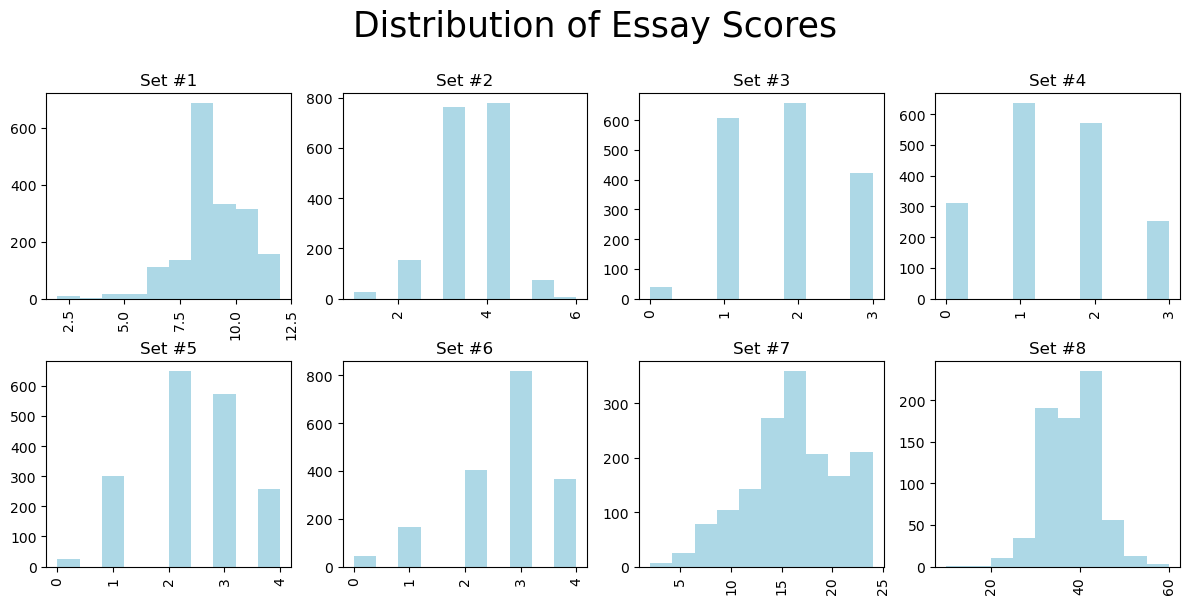

In [175]:
def create_plot(df, title, bar=False):
    fig, ax = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle(title, size=25, y=1.0)
    if bar:
        plots = []
        for r in range(len(ax)):
            for c in range(len(ax[0])):
                set_n = r*len(ax[0]) + c + 1
                p = df[df['essay_set']==set_n]['domain1_score'].value_counts().sort_index()
                plots.append(p.plot.bar(ax=ax[r][c], color={'red', 'blue'}, title=set_n))
    else:
        plots = df.hist('domain1_score', by='essay_set', ax=ax, color='lightblue').flatten()
    for p in plots:
        p.set_title("Set #{n}".format(n=p.title.get_text()))
    fig.tight_layout()
    
create_plot(essays_train, title="Distribution of Essay Scores")

### Unique Scores (by group)

In [173]:
for i in range(1, 9):
    val = list(essays_train['domain1_score'][essays_train['essay_set']==i].unique())
    print("Set #{n}: ({c})  {v}".format(n=i, v=val, c=len(val)))

Set #1: (11)  [8, 9, 7, 10, 6, 12, 4, 3, 11, 2, 5]
Set #2: (6)  [4, 1, 2, 5, 3, 6]
Set #3: (4)  [1, 2, 0, 3]
Set #4: (4)  [0, 3, 2, 1]
Set #5: (5)  [2, 3, 1, 4, 0]
Set #6: (5)  [2, 3, 4, 1, 0]
Set #7: (23)  [15, 13, 17, 23, 16, 18, 12, 10, 19, 14, 21, 24, 9, 6, 11, 20, 7, 8, 22, 4, 5, 2, 3]
Set #8: (34)  [34, 46, 40, 30, 26, 41, 31, 44, 36, 43, 20, 45, 35, 42, 33, 38, 47, 32, 50, 39, 37, 55, 60, 28, 49, 29, 27, 24, 15, 25, 48, 21, 22, 10]


### Binning the Essay Scores

Below we outline our exact decisions with respect to binning each essay set's scores into **4** categories. After binning in this manner, the resulting distributions appear to be fairly good.

---
**Set #1)**  Use the following groups:  [*2*-*7*], [ *8* ], [ *9* ], and [ *10*, *11*, *12* ]. This discretizes the data into 4 bins that are roughly of equal size as reasonably possible.

**Set #2)**  Merge scores *1* and *2*; as well as scores *5* and *6*. This should roughly balance out the categories as best as possible, whilst resulting in 4 groups.

**Set #3)**  Leave alone; it already has 4 categories.

**Set #4)**  Leave alone; it already has 4 categories.

**Set #5)**  Merge scores *0* and *1*. Very few essays have a rating of *0*, so merging with *1* will make all the categories fairly represented.

**Set #6)**  Merge scores *0* and *1*. For the same reason as above, the resulting groups will be fairly represented.

**Set #7)**  Auto-discretize into 4 bins using pd.qcut(), since there are a lot of categories.

**Set #8)**  Auto-discretize into 4 bins using pd.qcut(), since there are a lot of categories.

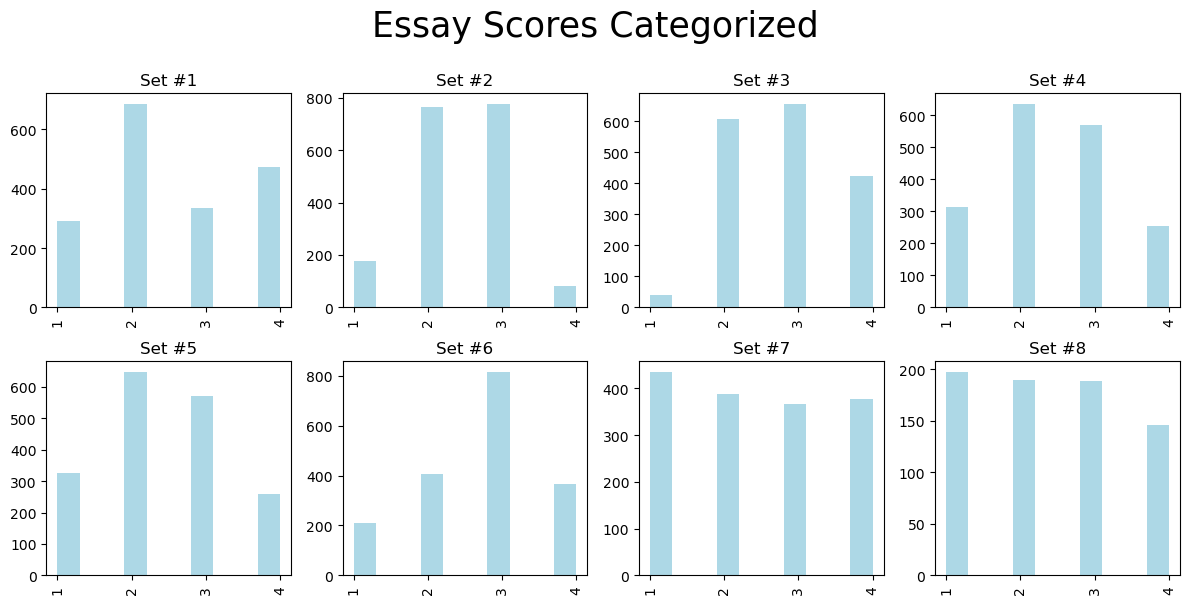

In [176]:
labels = [1, 2, 3, 4]
slices = [
    pd.cut(essays_train[essays_train['essay_set']==1]['domain1_score'], [1, 7, 8, 9, 12], labels=labels), # Set 1
    pd.cut(essays_train[essays_train['essay_set']==2]['domain1_score'], [0, 2, 3, 4, 6], labels=labels),
    essays_train[essays_train['essay_set']==3]['domain1_score'] + 1,
    essays_train[essays_train['essay_set']==4]['domain1_score'] + 1,
    pd.cut(essays_train[essays_train['essay_set']==5]['domain1_score'], [-1, 1, 2, 3, 4], labels=labels),
    pd.cut(essays_train[essays_train['essay_set']==6]['domain1_score'], [-1, 1, 2, 3, 4], labels=labels),
    pd.qcut(essays_train[essays_train['essay_set']==7]['domain1_score'], 4, labels=labels),
    pd.qcut(essays_train[essays_train['essay_set']==8]['domain1_score'], 4, labels=labels)
]
essays_categorized = essays_train[[c for c in essays_train.columns if c != 'domain1_score']]
essays_categorized = essays_categorized.join(pd.concat(slices))
create_plot(essays_categorized, title="Essay Scores Categorized")

### Sample Essays:

* Note that personally identifying information has been replaced with NER (Named Entity Recognition) tags [Ex: "Person", "Organization", etc.]

In [177]:
def show_essays(nsample=1, exclude=None):
    if not exclude: exclude = []
    for group in essays_train.groupby('essay_set'):
        group = group[1].reset_index()
        if not group['essay_set'][0] in exclude:
            print('---------------------------------- (Set {t}) --------------------------------'.format(t=group['essay_set'][0]))
            for _, row in group.sample(n=nsample).iterrows():
                score = row['domain1_score']
                print('\n(Score: {s})  {r}\n'.format(s=score, r=row['essay']))
                print("---------------------------------------------------------------------------")
                
show_essays()

---------------------------------- (Set 1) --------------------------------

(Score: 8)  Dear Newspaper, I disagree that computers are important to people because they have research, online colleges, and online stores. Those are my top @NUM1 reasons and I'm going to give more details. My first main idea is that computers help students find important information help students find important information on a project. You can do on the wikepedia to help find information about the battle of @LOCATION1 and other important history. one example is I went to american history.com to find good information about @CAPS1 alley @CAPS2 and what happened there. People also look up a lot of stuff that involves school. You can get research about the earth and what happens to it. My second main idea is that computers are good for people is when you finish high school, you can go to college. Some colleges can be found on the internet and you can go to college at home on your computer. One example is my co

### Summary Statistics

In [179]:
NER_tokens = []

for dataset in ['all', *essays_train['essay_set'].unique()]:
    data = essays_train if (dataset=='all') else essays_train[essays_train['essay_set']==dataset]
    
    word_tokens = set()
    char_tokens = set()
    sum_rev_len = 0
    for text in data['essay']:
        sum_rev_len += len(text)
        for token in re.split(r'\s{1,}', text):  word_tokens.add(token)
        for c in text:  char_tokens.add(c)
    print("------------- (Set {s}) --------------".format(s=dataset))
    print("# Essays:  ", len(data))
    print("# Unique words:  ", len(word_tokens))
    print("# Unique characters:  ", len(char_tokens))
    print("Average Essay Length:  ", np.round_(sum_rev_len / len(data), 2), "chars")
    if dataset == 'all':  NER_tokens = [w for w in word_tokens if w.startswith('@')]
    print()

------------- (Set all) --------------
# Essays:   12977
# Unique words:   78570
# Unique characters:   116
Average Essay Length:   1215.87 chars

------------- (Set 1) --------------
# Essays:   1783
# Unique words:   27286
# Unique characters:   98
Average Essay Length:   2029.39 chars

------------- (Set 2) --------------
# Essays:   1800
# Unique words:   24810
# Unique characters:   86
Average Essay Length:   2097.03 chars

------------- (Set 3) --------------
# Essays:   1726
# Unique words:   11131
# Unique characters:   89
Average Essay Length:   587.17 chars

------------- (Set 4) --------------
# Essays:   1771
# Unique words:   8398
# Unique characters:   90
Average Essay Length:   509.85 chars

------------- (Set 5) --------------
# Essays:   1805
# Unique words:   9119
# Unique characters:   85
Average Essay Length:   685.51 chars

------------- (Set 6) --------------
# Essays:   1800
# Unique words:   9729
# Unique characters:   88
Average Essay Length:   892.55 chars

--

### NER Tokens

* It appears that NER tokens have a number that comes after, perhaps indicating the number of that type of instance in each essay. This is reinforced by the fact that the lower the number, the higher the count (Ex: '@CAPS1: 10,509', '@LOCATION6: 8')

* It will probably be best to leave only the unique 'Token Types' tokenized, not including the number that comes after. Byte-pair encoding could probably take care of that. 

In [180]:
NER_tokens = set()
types = set()
count = {}

for text in essays_train['essay']:
    for token in re.split(r'\s{1,}', text):
        if(token.startswith('@')):
            result = re.search("@+[A-Z]+[0-9]*", token)
            if result:
                NER_tokens.add(result.group(0))
                types.add(re.search("@+[A-Z]+", token).group(0))
                if result.group(0) not in count:
                    count[result.group(0)] = 1
                else:
                    count[result.group(0)] += 1
    
print("Token Types: ({c}):  {s}\n".format(c=len(types), s=list(sorted(types))))
print("Unique Tokens: ({c}):  {s}\n".format(c=len(NER_tokens), s=list(sorted(NER_tokens))))
print("Counts: ", dict(sorted(count.items(), key=lambda x: x[0])))

Token Types: (14):  ['@CAPS', '@CITY', '@DATE', '@DR', '@EMAIL', '@LOCATION', '@MONEY', '@MONTH', '@NUM', '@ORGANIZATION', '@PERCENT', '@PERSON', '@STATE', '@TIME']

Unique Tokens: (118):  ['@CAPS1', '@CAPS10', '@CAPS11', '@CAPS12', '@CAPS13', '@CAPS14', '@CAPS15', '@CAPS16', '@CAPS17', '@CAPS18', '@CAPS19', '@CAPS2', '@CAPS20', '@CAPS21', '@CAPS22', '@CAPS23', '@CAPS24', '@CAPS25', '@CAPS26', '@CAPS27', '@CAPS28', '@CAPS29', '@CAPS3', '@CAPS30', '@CAPS31', '@CAPS32', '@CAPS33', '@CAPS34', '@CAPS35', '@CAPS36', '@CAPS38', '@CAPS39', '@CAPS4', '@CAPS40', '@CAPS41', '@CAPS43', '@CAPS46', '@CAPS49', '@CAPS5', '@CAPS53', '@CAPS54', '@CAPS56', '@CAPS6', '@CAPS62', '@CAPS63', '@CAPS66', '@CAPS67', '@CAPS7', '@CAPS73', '@CAPS8', '@CAPS9', '@CITY1', '@DATE1', '@DATE2', '@DATE3', '@DATE4', '@DATE5', '@DATE6', '@DR1', '@DR2', '@EMAIL1', '@LOCATION1', '@LOCATION10', '@LOCATION11', '@LOCATION12', '@LOCATION2', '@LOCATION3', '@LOCATION4', '@LOCATION5', '@LOCATION6', '@LOCATION7', '@LOCATION8', '@LO